# Clusterização de qualidade de vida

Utilizando a base de dados em anexo, crie um modelo de dados que faça um agrupamento dos países da base de dados com relação a níveis de qualidade de vida nesses países levando em consideração os dados fornecidos. 
Lembre-se de que o algoritmo não sabe do que se tratam os dados, logo cabe a você guiá-lo nesse agrupamento, escolher o que é mais relevante ou não, quais dados utilizar, quais desprezar.

## Dicionário
- country: Nome do país.
- child_mort: Morte de crianças menores de 5 anos de idade por 1.000 nascidos vivos.
- exports: Exportações de bens e serviços per capita. Dado como %idade do PIB per capita.
- health: Gasto total em saúde per capita. Dado como %idade do PIB per capita.
- imports: Importações de bens e serviços per capita. Dado como %idade do PIB per capita.
- income: Renda líquida por pessoa.
- inflation: A medição da taxa de crescimento anual do PIB total.
- life_expec: O número médio de anos que uma criança recém-nascida viveria se os padrões atuais de mortalidade permanecessem os mesmos.
- total_fer: O número de filhos que nasceriam de cada mulher se as atuais taxas de fertilidade por idade permanecessem as mesmas.
- gdpp: O PIB per capita. Calculado como o PIB total dividido pela população total.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Carregando os dados

In [2]:
data = pd.read_csv("./Country-data.csv");
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


## Informações sobre o dataframe utilizado

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Verificar se há valores ausentes no DF

In [5]:
missing_values = data.isnull().sum()
missing_values

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Como podemos notar, não há nenhum valor ausente em nosso dataframe, então não precisamos realizar nenhum tipo de tratamento enquanto à isso.

Bom agora que o nosso DF está "limpo", precisamos separar somente os valores(colunas) relevantes para a nossa clusterização. Tendo em mente que o objetivo final desse projeto é clusterizar os países do DF de acordo com a qualidade de vida cada um, precisa separar algumas colunas com dados valiosos para esse tipo de análise, vale ressaltar que o termo "qualidade de vida" pode ser muito subjetivo em relação à cada individuo, porém neste projeto iremos utilizar como parâmetro dados como: **Mortalidade infantil, saúde, expectativa de vida e o PIB(GDPP)**.

*Não irei utilizar a inflação, porque ela está diretamente ligada com o PIB do país, então querendo ou não estarei utilizando ela de forma indireta*

## Tratamento dos dados do dataframe para a clusterização

Remoção das colunas "não relevantes" para essa análise:

In [6]:
relevant_columns = ['life_expec', 'income', 'inflation', 'gdpp', 'child_mort']
data_selected = data[relevant_columns]
data_selected.head()

,life_expec,income,inflation,gdpp,child_mort
0,56.2,1610,9.44,553,90.2
1,76.3,9930,4.49,4090,16.6
2,76.5,12900,16.10,4460,27.3
3,60.1,5900,22.40,3530,119.0
4,76.8,19100,1.44,12200,10.3


## Pós-processamento dos dados

Por que normalizar os dados?

Em muitos algoritmos de machine learning, como o K-means, a distância entre os pontos de dados é uma métrica fundamental para a criação de agrupamentos. Se as características têm escalas muito diferentes (por exemplo, PIB em milhões de dólares e taxas de desemprego em porcentagem), a característica com a maior escala pode dominar a métrica de distância, tornando as outras características praticamente irrelevantes.

In [7]:
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_selected)
data_normalized = pd.DataFrame(data_normalized, columns=relevant_columns)
data_normalized

,life_expec,income,inflation,gdpp,child_mort
0,-1.619092,-0.808245,0.157336,-0.679180,1.291532
1,0.647866,-0.375369,-0.312347,-0.485623,-0.538949
2,0.670423,-0.220844,0.789274,-0.465376,-0.272833
3,-1.179234,-0.585043,1.387054,-0.516268,2.007808
4,0.704258,0.101732,-0.601749,-0.041817,-0.695634
...,...,...,...,...,...
162,-0.852161,-0.738527,-0.489784,-0.546913,-0.225578
163,0.546361,-0.033542,3.616865,0.029323,-0.526514
164,0.286958,-0.658404,0.409732,-0.637754,-0.372315
165,-0.344633,-0.658924,1.500916,-0.637754,0.448417


## WCSS (Método do cotovelo)

Neste trecho de código abaixo, testamos diferentes quantidades de clusters para nosso algoritmo, de 1 a 10 mais especificamente. Após isso treinamos o algoritmo com os dados normalizados e agregamos a variável *intertia_* à lista `WCSS`. Com esses dados criamos um gráfico para tentar encontrar a quantidade de clusters ideal para o algoritmo.

In [8]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_normalized)
    wcss.append(kmeans.inertia_)

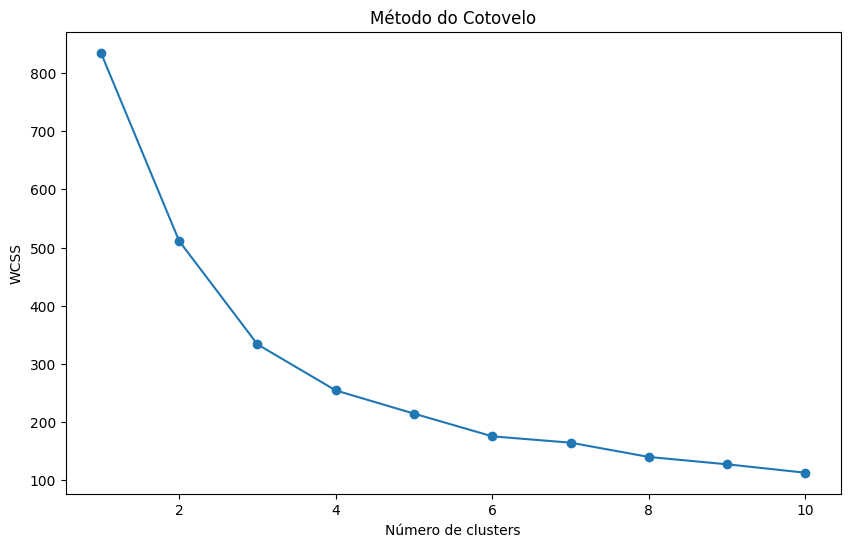

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker="o", linestyle="-")
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

Podemos perceber que após aplicarmos o método do cotovelo, o número de clusters ideal, aproximadamente é de `3`, então é hora de aplicarmos isso ao algoritmo de classificação K-Means

# Aplicando o K-Means como número ideal de clusters

`kmeans` -> Definindo o modelo de algoritmo de classificação

`clusters` -> Usando o modelo para fazer a previsão

In [10]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_normalized)

print(clusters)

[2 0 0 2 0 0 0 1 1 0 0 1 0 0 0 1 0 2 0 0 0 2 0 1 0 2 2 0 2 1 0 2 2 0 0 0 2
 2 2 0 2 0 1 0 1 0 0 0 0 2 2 0 0 1 1 2 2 0 1 2 1 0 0 2 2 0 2 0 1 2 0 0 0 1
 1 1 0 1 0 0 2 2 1 0 2 0 0 2 2 0 0 1 0 2 2 0 0 2 0 2 0 0 0 0 0 0 2 2 2 0 1
 1 2 2 1 1 2 0 0 0 0 0 1 1 0 0 2 0 1 2 0 0 2 1 0 1 0 2 1 1 0 0 2 0 1 1 0 2
 0 2 2 0 0 0 0 2 0 1 1 1 0 0 0 0 0 2 2]


`kmeans.fit_predict(data_normalized)` retorna um array de predições feitas para cada país do DF (167)

Agora iremos pegar esses dados que foram previstos e colocar no DF(data) para que possamos os países e seus clusters:

In [11]:
data['Cluster'] = clusters
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


## Apresentando os dados

Agora iremos organizar os dados do DF `data` pela coluna "Cluster", depois vamos criar uma pontuação de qualidade de vida para cada país do DF e organizá-los de forma decrescente e por fim, mostrar os 20 países do topo da lista.

Também podemos mapear os valores de 0,1 e 2 para "Ótimo", "Boa" e "Ruim" para facilitar o entendimento.

In [12]:
data_sorted_by_cluster = data.sort_values(by='Cluster')

In [13]:
data['quality_of_life'] = (data['life_expec'] + data['income'] - data['child_mort']) / 3

best_life_quality = data.sort_values(by='quality_of_life', ascending=False)
best_life_quality["Cluster"] = best_life_quality["Cluster"].map({0: "Boa", 1: "Ótima", 2:"Ruim"})
best_life_quality[['country', 'Cluster', 'quality_of_life']].head(20)

,country,Cluster,quality_of_life
123,Qatar,Ótima,41690.166667
91,Luxembourg,Ótima,30592.833333
23,Brunei,Ótima,26888.866667
82,Kuwait,Ótima,25089.133333
133,Singapore,Ótima,24059.966667
114,Norway,Ótima,20792.600000
157,United Arab Emirates,Ótima,19222.633333
145,Switzerland,Ótima,18525.900000
159,United States,Ótima,16490.466667
73,Ireland,Ótima,15258.733333


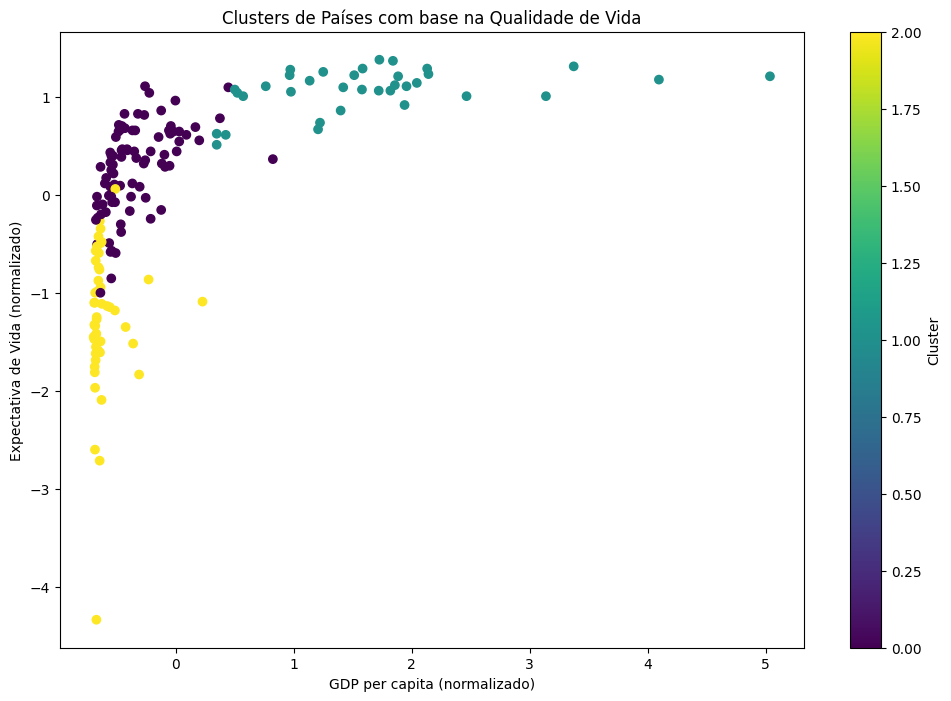

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(data_normalized['gdpp'], data_normalized['life_expec'], c=clusters, cmap='viridis')
plt.xlabel('GDP per capita (normalizado)')
plt.ylabel('Expectativa de Vida (normalizado)')
plt.title('Clusters de Países com base na Qualidade de Vida')
plt.colorbar(label='Cluster')
plt.show()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster,quality_of_life
123,Qatar,9.0,62.30,1.81,23.8,125000,6.980,79.5,2.07,70300,Ótima,41690.166667
91,Luxembourg,2.8,175.00,7.77,142.0,91700,3.620,81.3,1.63,105000,Ótima,30592.833333
23,Brunei,10.5,67.40,2.84,28.0,80600,16.700,77.1,1.84,35300,Ótima,26888.866667
82,Kuwait,10.8,66.70,2.63,30.4,75200,11.200,78.2,2.21,38500,Ótima,25089.133333
133,Singapore,2.8,200.00,3.96,174.0,72100,-0.046,82.7,1.15,46600,Ótima,24059.966667
...,...,...,...,...,...,...,...,...,...,...,...,...
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446,Ruim,262.166667
112,Niger,123.0,22.20,5.16,49.1,814,2.550,58.8,7.49,348,Ruim,249.933333
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,Ruim,242.700000
88,Liberia,89.3,19.10,11.80,92.6,700,5.470,60.8,5.02,327,Ruim,223.833333


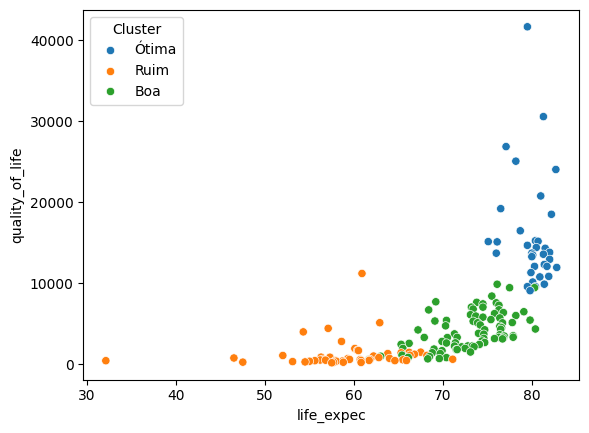

In [15]:
sns.scatterplot(data=best_life_quality, x="life_expec", y="quality_of_life", hue="Cluster")
best_life_quality

Podemos perceber que, no gráfico de dispersão, há alguns países com qualidade de vida classificada como "Ruim" junto a países classificados como "Ótimo". Mas por quê?

Bom, como fizemos anteriormente, neste algoritmo utilizamos duas métricas:

- Predição do algoritmo K-Means
- Pontuação de qualidade de vida dada por: (expectativa de vida + renda - mortalidade infantil)

### Conclusão
Sempre é importante lembrar que o algoritmo pode não fornecer **100% de precisão** nas previsões. Portanto, alguns dados podem estar um pouco desorganizados devido à **divergência** entre os dados que escolhemos utilizar. Também vale lembrar que o DataFrame `best_life_quality` foi ordenado de forma **decrescente em relação à coluna `quality_of_life`**. Assim, pode ser que alguns países classificados como "Ruim" tenham uma pontuação maior do que alguns países classificados como "Ótimo". Da mesma forma, países classificados como "Bom" podem aparecer antes de "Ótimo" e assim por diante.

É claro que, se rodarmos este algoritmo novamente utilizando mais colunas ou colunas diferentes, o resultado pode variar, podendo ser melhor ou pior. No entanto, como este projeto foi desenvolvido para estudos e avaliação, vou testá-lo da maneira que faz mais sentido para mim. Acredito que é benéfico surgirem situações como essa, pois nos ajudam a entender melhor o funcionamento do algoritmo proposto e a alcançar nosso objetivo em relação a esses estudos.

# Gerando resultados

Agora para finalizarmos iremos exportar os dados para um arquivo `csv`

In [16]:
best_life_quality[['country', 'Cluster', 'quality_of_life']].to_csv('resultado.csv', sep=',', index=False, encoding='utf-8')